### CS 178: Machine Learning &amp; Data Mining

# Final Project: CNN on Facial Expressions


In [2]:
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
#import imageio
import cv2
#import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
# import seaborn as sns

# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


#### 1.2 Loading in legend 

In [85]:
# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy= False

## downloading csv label file
## facial_df = facial dataframe
labels_url = "https://raw.githubusercontent.com/muxspace/facial_expressions/master/data/legend.csv"
facial_df = pd.read_csv(labels_url)
if toy:
    facial_df = facial_df.sample(500)

facial_df.head() #head returns first [.head(n)] n values

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


##### Preprocessing
Emotion labels are case-sensitive. So, need to preprocess and make them all the same.

In [86]:
facial_df['emotion'] = facial_df['emotion'].str.lower()
facial_labels = facial_df.emotion.unique()

##### Visualizing Labels

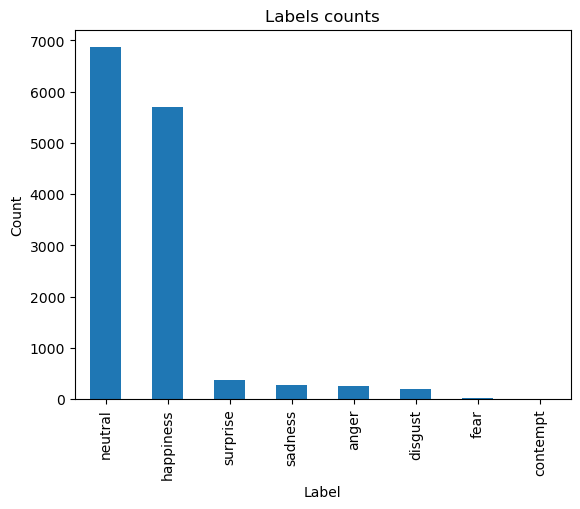

In [87]:
facial_df.emotion.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

##### Visualizing Images (Basic)

../CS 178/cs178_facial_expressions/images/Dan_Dickau_0001.jpg
../CS 178/cs178_facial_expressions/images/Hillary_Clinton_0008.jpg
../CS 178/cs178_facial_expressions/images/Jayamadhuri_165.jpg
../CS 178/cs178_facial_expressions/images/John_Ashcroft_0028.jpg
../CS 178/cs178_facial_expressions/images/George_W_Bush_0148.jpg
../CS 178/cs178_facial_expressions/images/Jayamadhuri_43.jpg
../CS 178/cs178_facial_expressions/images/Dwarakish_9.jpg
../CS 178/cs178_facial_expressions/images/Milan_Kucan_0001.jpg


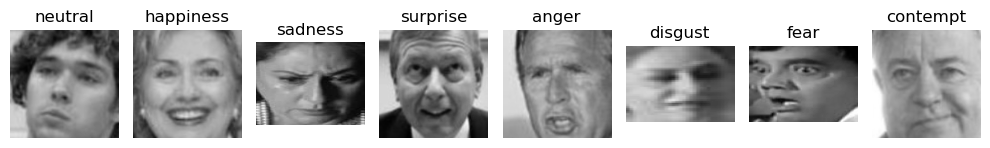

In [98]:
from io import BytesIO
from PIL import Image
import urllib



class ImageViewer:
    def read_img(self,id, folder="images"):
        """
        Read image by it's image name [id]
        """
        file = "../CS 178/cs178_facial_expressions/" + folder + "/" + id
        print(file)
        im=cv2.imread(str(file),  cv2.IMREAD_GRAYSCALE)
        return im

    def draw_sample_images(self):
        """
        Draws images for each label.
        labels: ['neutral' 'happiness' 'sadness' 'surprise' 'anger' 'disgust' 'fear' 'contempt']
        """
        ncols=8
        fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(10,7))
        
        labels=  ['neutral', 'happiness', 'sadness', 'surprise', 'anger' ,'disgust', 'fear', 'contempt']

        for col in range(0,ncols):
            try:
                sample = facial_df[facial_df['emotion']==labels[col]]['image'].sample(1).values
            except ValueError:
                continue
            
            im=self.read_img(sample[0])
            
            # [makes images appear the same size] Calculate the aspect ratio to maintain the original image proportions
            aspect_ratio = im.shape[1] / im.shape[0]
            ax[col].imshow(im, cmap="gray", vmin=0, vmax=255, extent=[0, 1, 0, 1 * aspect_ratio])
            

            ax[col].set_title(labels[col])
            ax[col].axis('off')  # Turn off axis labels
        fig.tight_layout()
        
testing = ImageViewer()
testing.draw_sample_images()



## Playing with sift

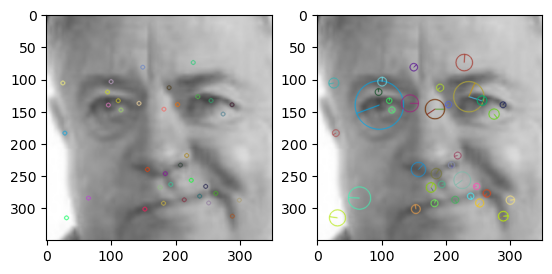

In [115]:
fig, ax =  plt.subplots(1, 2) # , figsize=(10,7))

#reading image
img = cv2.imread('../CS 178/cs178_facial_expressions/images/Milan_Kucan_0001.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)



img=cv2.drawKeypoints(gray,kp,img)# ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flags: shows circle of size of kp and will show it's orientation
cv2.imwrite('sift_keypoints.jpg',img)
ax[0].imshow(img)

img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #flags: shows circle of size of kp and will show it's orientation
cv2.imwrite('sift_keypoints.jpg',img)
ax[1].imshow(img)
# gives us data we can use des: numpy array of shape (num of kp) x 128
kp,des = sift.compute(gray,kp)

### Comparing Images w/ SIFT

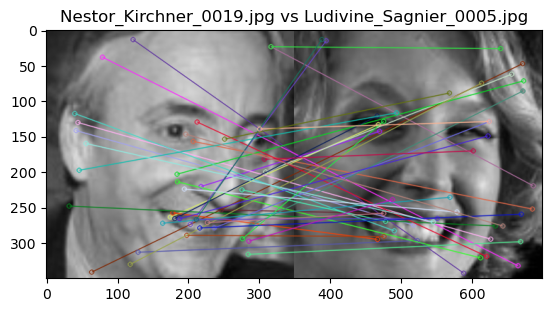

num of matches: 42
24.0


In [154]:
avg_matches = 0
total = 0
iter = 1

while True:
    sample = facial_df[facial_df['emotion']=="happiness"]['image'].sample(2).values
    
    img1 = "../CS 178/cs178_facial_expressions/images/" + str(sample[0])
    img2 = "../CS 178/cs178_facial_expressions/images/" + str(sample[1])
    
    #reading images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #sift
    sift = cv2.SIFT_create() # creates a sift object
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    
    
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    if len(matches) > 40:
        img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
        plt.title(f"{sample[0]} vs {sample[1]}")
        plt.imshow(img3),plt.show()
        
        print("num of matches:", len(matches))
    
    total += len(matches)

    if iter == 50:
        avg_matches = total/iter
        break
    iter += 1
print(avg_matches)

# over 50
# test 1: avg = 21.94
# test 2: avg = 22.9
# test 3: avg = 24

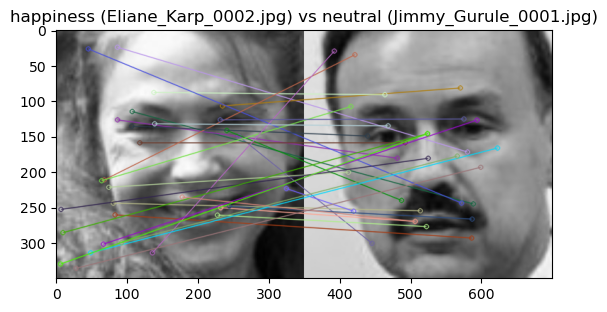

num of matches: 30


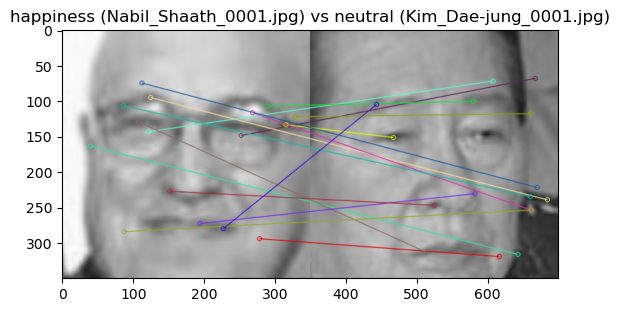

num of matches: 16


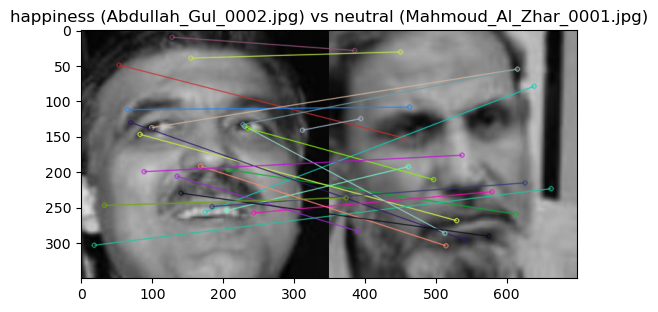

num of matches: 23


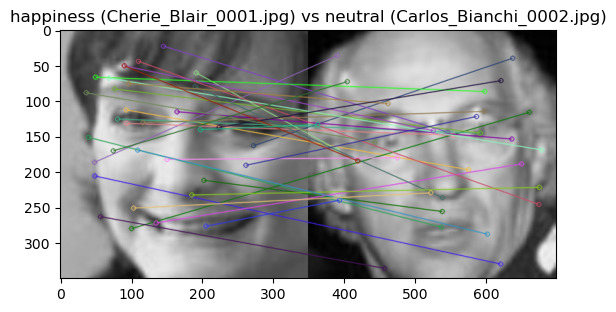

num of matches: 33


In [157]:
iter = 0
while True:
    iter += 1
    if iter == 5:
        break
        
    sample = facial_df[facial_df['emotion']=="happiness"]['image'].sample(1).values
    sample2 = facial_df[facial_df['emotion']=="neutral"]['image'].sample(1).values
    
    img1 = "../CS 178/cs178_facial_expressions/images/" + str(sample[0])
    img2 = "../CS 178/cs178_facial_expressions/images/" + str(sample2[0])
    
    #reading images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #sift
    sift = cv2.SIFT_create() # creates a sift object
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    
    
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)

    img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
    plt.title(f"happiness ({sample[0]}) vs neutral ({sample2[0]})")
    plt.imshow(img3),plt.show()
    
    print("num of matches:", len(matches))
    

# over 50
# test 1: avg = 21.94
# test 2: avg = 22.9
# test 3: avg = 24